In [56]:
# HELPER FUNCTIONS

import collections

def get_mean_metrics(models, metric_type):
    mean_acc_fedavg = []
    for model in models["result"]:
        model_id = model["model"]
        validations = client.list_validations(modelId=model_id)

        acc = []
        for _, validation in validations.items(): 
            metrics = json.loads(validation['data'])
            if metric_type in metrics:
                acc.append(metrics[metric_type])

        if acc:
            mean_acc_fedavg.append(np.mean(acc))

    return np.min(mean_acc_fedavg)

def get_baseline_metrics(baseline_session_id):
    models = client.list_models(baseline_session_id)

    baseline_metrics = {
        'train_target_misclassification': get_mean_metrics(models, 'train_target_misclassification'),
        'test_target_misclassification': get_mean_metrics(models, 'test_target_misclassification')
    }

    return baseline_metrics

In [57]:
from fedn import APIClient
import time
import uuid
import json
import matplotlib.pyplot as plt
import numpy as np
import collections

import sys
sys.path.append('/home/ubuntu/fedn-attack-sim-uu/examples/mnist-pytorch')

from combiner_config import COMBINER_IP

DISCOVER_HOST = COMBINER_IP
DISCOVER_PORT = 8092
client = APIClient(DISCOVER_HOST, DISCOVER_PORT)

In [58]:
[session['session_id'] for session in client.list_sessions()['result']]

['MNIST_BD35IN__P_25R_TAKE02_20_00',
 'MNIST_BD35IN03P_25R_TAKE03_19_01',
 'MNIST_BD35IN03P_25R_TAKE03_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_18_02',
 'MNIST_BD35IN03P_25R_TAKE01_18_02',
 'MNIST_BD35IN03P_25R_TAKE02_19_01',
 'MNIST_BD35IN03P_25R_19_01_TAKE02',
 'MNIST_BD35IN__P_25R_20_00',
 'TEST_FINAL_01_18_02',
 'MNIST_BD35IN03P_25R_18_02_T3',
 'MNIST_BD35IN03P_25R_18_02_T2',
 'MNIST_BD35IN03P_25R_18_02_T1',
 'MNIST_BD35IN03P_25R_18_02',
 'MNIST_BD35IN03P_25R_19_01',
 'MNIST_BD__IN_25R_20_00',
 'MNIST_BD35IN_25R_19_01_T1',
 'MNIST_BD35IN_25R_19_01_V2',
 'MNIST_BD35IN_25R_19_01',
 'TEST_05',
 'TEST_04',
 'TEST_03',
 'MNIST_AB35IN_25R_08_12',
 'MNIST_AB35IN_25R_12_08',
 'TEST_02',
 'MNIST_AB35IN_25R_14_06',
 'MNIST_AB35IN_25R_16_04',
 'MNIST_GBM001_25R_18_02',
 'MNIST_AB35IN_25R_09_01',
 'MNIST_AB35IN_25R_18_02_V2',
 'TEST',
 'MNIST_AB35IN_25R_18_02',
 'MNIST_AB35IN_25R_19_01',
 'MNIST_AB__IN_25R_20_00']

In [59]:
session_id = input("Provide a session_id: ")

Provide a session_id:  MNIST_BD35IN03P_25R_TAKE03_18_02


In [60]:
baseline_metrics = get_baseline_metrics(input("Provide baseline session_id: "))

Provide baseline session_id:  MNIST_BD35IN__P_25R_20_00


In [61]:
models = client.list_models(session_id)

num_rounds = models['count']
# num_rounds

# Provides a model trail for a given session (in FILO) --> need to be reversed
model_trail = models['result']
model_trail.reverse()
# model_trail

In [62]:
# client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']

In [63]:
# json.loads(client.list_validations(modelId = model_trail[20]['model'])['663757fd981afd046cebee22']['data'])

In [64]:
# for round in range(num_rounds):
#     for client_model in client.list_validations(modelId = model_trail[round]['model']).keys():
#         print(json.loads(client.list_validations(modelId = model_trail[round]['model'])[client_model]['data'])['train_target_misclassification'])

In [65]:
validations = []

for model_instance in model_trail:
    worker_results = client.list_validations(modelId=model_instance['model'])
    result_ids = [result_id for result_id in worker_results]
    for result_id in result_ids:
        worker_result = worker_results.get(result_id)
        client_type = 'benign'
        
        if 'malicious' in worker_result['sender']['name']:
            client_type = 'malicious'
            
        validation = {
            'model_committed_at': model_instance['committed_at'],
            'session_id': model_instance['session_id'],
            'model': model_instance['model'],
            'client_name': worker_result['sender']['name'],
            'client_role': worker_result['sender']['role'],
            'client_type': client_type,
            'train_target_misclassification': json.loads(worker_result['data'])['train_target_misclassification'],
            'test_target_misclassification': json.loads(worker_result['data'])['test_target_misclassification'],
            'train_target_prediction_dist': json.loads(worker_result['data'])['train_target_prediction_dist'],
            'test_target_prediction_dist': json.loads(worker_result['data'])['test_target_prediction_dist']
        }
        
        validations.append(validation)

In [66]:
validations[0]

{'model_committed_at': 'Thu, 09 May 2024 19:46:49 GMT',
 'session_id': 'MNIST_BD35IN03P_25R_TAKE03_18_02',
 'model': '6416464c-3e81-4cc1-ae2e-dbebde603bf5',
 'client_name': 'benign_client10',
 'client_role': 'WORKER',
 'client_type': 'benign',
 'train_target_misclassification': 0.9759450171821306,
 'test_target_misclassification': 0.9811320754716981,
 'train_target_prediction_dist': [54, 0, 7, 48, 131, 0, 0, 21, 7, 23],
 'test_target_prediction_dist': [11, 0, 0, 4, 22, 0, 0, 12, 1, 3]}

In [67]:
graph_data = {
    'train_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_misclassification': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'train_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'test_target_prediction_dist': {
        client: {'data': [], 'type': client.split(sep='_')[0]} for client in set([validation['client_name'] for validation in validations])
    },
    'overall_train_target_misclassification': [],
    'overall_test_target_misclassification': [],
    'overall_train_target_prediction_dist': [],
    'overall_test_target_prediction_dist': []
}

In [68]:
for validation in validations:
    graph_data['train_target_misclassification'][validation['client_name']]['data'].append(validation['train_target_misclassification'])
    graph_data['test_target_misclassification'][validation['client_name']]['data'].append(validation['test_target_misclassification'])
    graph_data['train_target_prediction_dist'][validation['client_name']]['data'].append(validation['train_target_prediction_dist'])
    graph_data['test_target_prediction_dist'][validation['client_name']]['data'].append(validation['test_target_prediction_dist'])

In [69]:
graph_data['train_target_prediction_dist']

{'benign_client16': {'data': [[77, 0, 4, 41, 131, 0, 0, 25, 6, 21],
   [63, 0, 0, 16, 50, 0, 0, 23, 99, 54],
   [51, 4, 0, 4, 6, 0, 0, 28, 201, 11],
   [54, 3, 0, 1, 0, 0, 0, 27, 216, 4],
   [57, 3, 0, 0, 0, 0, 0, 35, 204, 6],
   [57, 9, 0, 1, 0, 0, 8, 42, 174, 14],
   [35, 19, 0, 2, 2, 14, 42, 32, 111, 48],
   [16, 25, 0, 18, 9, 47, 42, 15, 63, 70],
   [12, 44, 6, 21, 14, 65, 33, 6, 32, 72],
   [10, 65, 7, 25, 16, 83, 27, 2, 22, 48],
   [10, 70, 10, 29, 16, 99, 18, 0, 11, 42],
   [7, 69, 14, 33, 16, 109, 13, 0, 7, 37],
   [6, 68, 16, 34, 15, 112, 13, 0, 6, 35],
   [6, 64, 18, 36, 14, 113, 13, 0, 6, 35],
   [6, 64, 21, 38, 13, 113, 11, 0, 7, 32],
   [6, 58, 22, 45, 12, 116, 10, 0, 6, 30],
   [7, 55, 24, 47, 12, 115, 10, 0, 5, 30],
   [7, 54, 25, 48, 12, 115, 9, 0, 4, 31],
   [7, 56, 25, 47, 11, 114, 9, 0, 4, 32],
   [7, 55, 25, 48, 11, 115, 9, 0, 4, 31],
   [7, 55, 25, 48, 11, 116, 10, 0, 3, 30],
   [7, 54, 23, 46, 9, 119, 12, 1, 3, 31],
   [7, 53, 23, 47, 9, 121, 12, 1, 3, 29],
   [7,

In [70]:
graph_data['overall_train_target_misclassification'] = [np.mean([graph_data['train_target_misclassification'][key]['data'][i] for key in graph_data['train_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_test_target_misclassification'] = [np.mean([graph_data['test_target_misclassification'][key]['data'][i] for key in graph_data['test_target_misclassification'].keys()]) for i in range(num_rounds)]
graph_data['overall_train_target_prediction_dist'] = [np.sum([graph_data['train_target_prediction_dist'][key]['data'][i] for key in graph_data['train_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]
graph_data['overall_test_target_prediction_dist'] = [np.sum([graph_data['test_target_prediction_dist'][key]['data'][i] for key in graph_data['test_target_prediction_dist'].keys()], axis = 0).tolist() for i in range(num_rounds)]

In [71]:
graph_data['overall_test_target_prediction_dist']

[[187, 0, 11, 134, 441, 0, 0, 76, 30, 95],
 [148, 0, 0, 52, 146, 0, 1, 70, 418, 139],
 [125, 2, 0, 11, 10, 0, 2, 81, 709, 34],
 [149, 4, 0, 0, 2, 0, 0, 83, 731, 5],
 [146, 6, 0, 1, 1, 0, 5, 125, 689, 1],
 [140, 13, 0, 3, 8, 1, 44, 150, 592, 23],
 [99, 29, 1, 11, 16, 31, 134, 103, 395, 155],
 [56, 55, 3, 16, 47, 105, 154, 61, 211, 266],
 [28, 108, 10, 33, 78, 198, 109, 41, 113, 256],
 [17, 156, 16, 56, 88, 255, 86, 29, 66, 205],
 [14, 181, 27, 63, 84, 301, 71, 23, 37, 173],
 [12, 175, 39, 72, 81, 332, 63, 23, 27, 150],
 [10, 165, 42, 79, 73, 360, 59, 24, 26, 136],
 [9, 152, 49, 88, 74, 373, 54, 24, 25, 126],
 [8, 142, 59, 98, 74, 375, 51, 24, 23, 120],
 [8, 137, 64, 107, 73, 377, 53, 23, 21, 111],
 [9, 129, 64, 115, 69, 381, 53, 22, 22, 110],
 [10, 125, 66, 120, 67, 381, 53, 21, 22, 109],
 [10, 124, 65, 123, 65, 383, 55, 21, 21, 107],
 [10, 123, 70, 124, 62, 382, 55, 21, 19, 108],
 [10, 120, 71, 121, 63, 387, 55, 22, 18, 107],
 [10, 118, 74, 121, 62, 391, 53, 23, 17, 105],
 [11, 116, 72

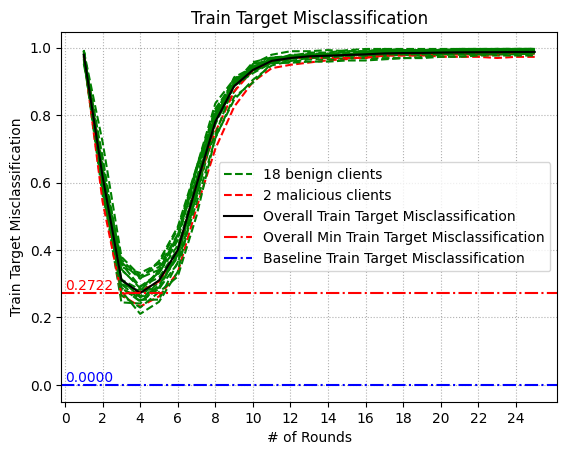

In [72]:
x = range(1, num_rounds + 1)
metric_type = "train_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

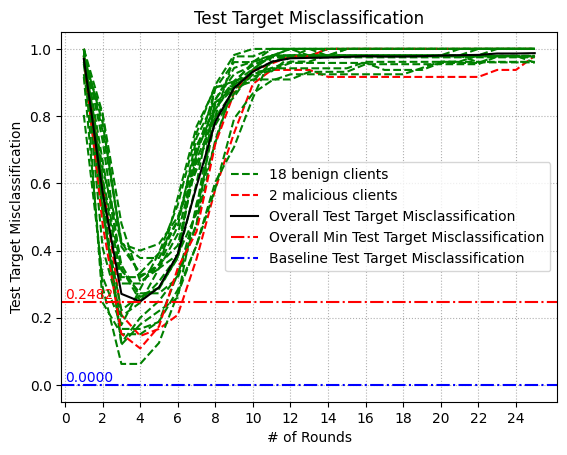

In [73]:
x = range(1, num_rounds + 1)
metric_type = "test_target_misclassification"

benign_counter = 0
malicious_counter = 0

# Plot actual data
for i in range(len(graph_data[metric_type])):
    if graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'benign':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='green', linestyle='--')
        benign_counter += 1
    elif graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['type'] == 'malicious':
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='red', linestyle='--')
        malicious_counter += 1
    else:
        plt.plot(x, graph_data[metric_type][list(graph_data[metric_type].keys())[i]]['data'], color='black', linestyle='--')
    
plt.plot(x, graph_data[f'overall_{metric_type}'], color='black')

# Plot dummy lines with desired labels
plt.plot([], color='green', linestyle='--', label=f'{benign_counter} benign clients')
plt.plot([], color='red', linestyle='--', label=f'{malicious_counter} malicious clients')
plt.plot([], color='black', label=f'Overall {metric_type.replace("_", " ").title()}')

# Add a horizontal line for baseline max and overall max accuracies
plt.axhline(y=np.min(graph_data[f'overall_{metric_type}']), color='red', linestyle='-.', label=f'Overall Min {metric_type.replace("_", " ").title()}')
plt.text(0, np.min(graph_data[f'overall_{metric_type}']), f'{np.min(graph_data["overall_" + str(metric_type)]):.4f}', ha='left', va='bottom', color='red')

plt.axhline(y=baseline_metrics[metric_type], color='blue', linestyle='-.', label=f'Baseline {metric_type.replace("_", " ").title()}')

# Add text to y-axis
plt.text(0, baseline_metrics[metric_type], f'{baseline_metrics[metric_type]:.4f}', ha='left', va='bottom', color='blue')

# Add axis labels and title
plt.title(metric_type.replace("_", " ").title())
plt.xlabel(f'# of Rounds')
plt.ylabel(metric_type.replace("_", " ").title())

# Create legend with custom labels
plt.legend()
plt.grid(True, linestyle=':')
plt.xticks(np.arange(0, num_rounds + 1, 2))

plt.show()

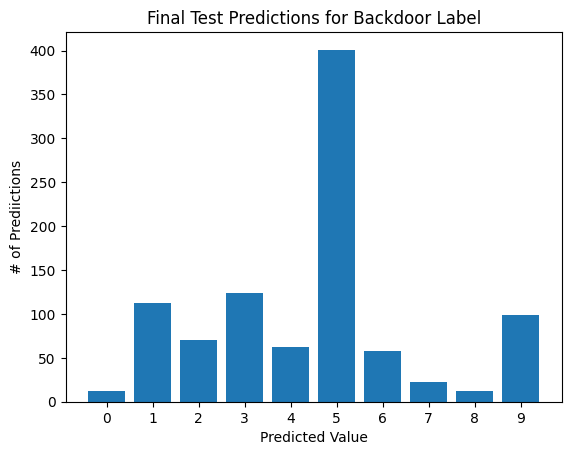

In [74]:
# Generate x-values as the index numbers of the list
data = graph_data['overall_test_target_prediction_dist'][-1]
x = range(len(data))

# Plot the bar chart
plt.bar(x, data)

# Add labels and title
plt.xlabel('Predicted Value')
plt.ylabel('# of Prediictions')
plt.title('Final Test Predictions for Backdoor Label')
plt.xticks(np.arange(0, 10, 1))

# Show the plot
plt.show()